In [1]:
""" Filter based on h3 hexagons mapped to polygons

aws emr add-steps --cluster-id <Your EMR cluster id> --steps Type=spark,Name=TestJob,Args=[--deploy-mode,cluster,--master,yarn,--conf,spark.yarn.submit.waitAppCompletion=true,s3a://your-source-bucket/code/pythonjob.py,s3a://your-source-bucket/data/data.csv,s3a://your-destination-bucket/test-output/],ActionOnFailure=CONTINUE
"""

from collections import namedtuple
import logging
import sys

from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import udf
from sedona.utils.adapter import Adapter
#from sedona.core.formatMapper.geojsonReader import GeoJsonReader
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.SpatialRDD import PointRDD, SpatialRDD, CircleRDD
from sedona.sql.types import GeometryType
from sedona.core.enums import GridType
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import JoinQuery
from sedona.core.enums import IndexType
from sedona.core.formatMapper.disc_utils import load_spatial_rdd_from_disc, GeoType
from sedona.core.formatMapper import WktReader


import pyproj

from geopy.distance import great_circle
import pandas as pd
import geopandas as gpd
import os

from datetime import timedelta, date, datetime
from statistics import *

from pyspark import SparkContext

from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StructType,
    LongType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
    TimestampType,
    ArrayType
)
from pyspark.sql.functions import (
    from_utc_timestamp,
    to_utc_timestamp,
    dayofyear,
    col,
    unix_timestamp,
    monotonically_increasing_id,
    pandas_udf,
    PandasUDFType,
    col,
    asc,
    lit,
    countDistinct,
)
import pyspark.sql.functions as F
from math import *
import time

from shapely.wkt import loads as wkt_loads
from shapely.geometry import Point, Polygon, shape
from shapely.ops import transform
import shapely

from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable


spark = (SparkSession.builder.appName("sedona")
                 .config("spark.serializer", KryoSerializer.getName)          
        .config("spark.kryo.registrator",     
                  SedonaKryoRegistrator.getName)    
         .config("spark.driver.maxResultSize", "3g")
    .getOrCreate() 
        )


# Register Sedona UDTs and UDFs
SedonaRegistrator.registerAll(spark)

spark.sparkContext.addPyFile("s3://ipsos-dvd/scripts/utils.py")
from utils import *
import h3_pyspark as h3s
#import h3pandas 
import h3 as h3
import io
import json


s3 = boto3.client('s3')


#------
# parameters
#------

data_dir = "s3://external-safegraph/"
data_dyn = "s3://ipsos-dvd/dyn/data/"
figs_dir = "s3://ipsos-dvd/dyn/results/figs/"
tabs_dir =  "s3://ipsos-dvd/dyn/results/tabs/"
data_veraset = "s3://external-veraset-data-us-west-2/us/"
data_wages = "s3://external-wagescape/"

import s3fs
fs = s3fs.S3FileSystem()

# ----- install pypi packages
sc.install_pypi_package("plotly")
sc.install_pypi_package("thefuzz")
sc.install_pypi_package("FixedEffectModel")
sc.install_pypi_package("name_matching")

from fixedeffect.iv import iv2sls, ivgmm, ivtest
from fixedeffect.fe import fixedeffect, did, getfe
from fixedeffect.utils.panel_dgp import gen_data

from thefuzz import process, fuzz
import plotly.express as px


def saveFigS3(fig_prefix, bucket = "ipsos-dvd", **kwargs):
    
    # Create an s3 client
    s3 = boto3.client('s3')
    
    plt.savefig("tempfig.pdf", **kwargs)

    s3.upload_file('tempfig.pdf',bucket, fig_prefix)

    
from name_matching.name_matcher import NameMatcher
from name_matching.sparse_cosine import sparse_cosine_top_n


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
10,application_1709223206931_0011,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 140.0 MB/s eta 0:00:00

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 195.3 MB/s eta 0:00:00

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 170.4 MB/s eta 0:00:00

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 65.3 MB/s eta 0:00:00





In [2]:
#### Define functions

def spatialIntersection(pings, poly, build_on_spatial_partitioned_rdd = True, using_index = True, origin_crs="epsg:4326", crs="epsg:4326", transform=True): 
    
    poly_rdd = Adapter.toSpatialRdd(poly, "geometry")

    pings.createOrReplaceTempView("pings")

    # Read Hive table
    if transform:
        pings = spark.sql(
              f"""SELECT ST_Transform(ST_FlipCoordinates(ST_Point(pings.longitude, 
              pings.latitude)), "{origin_crs}", "{crs}") AS point, 
              *
              FROM pings;
              """
        )
    else:
        pings = spark.sql(
              f"""SELECT ST_FlipCoordinates(ST_Transform(ST_FlipCoordinates(ST_Point(pings.longitude, 
              pings.latitude)), "{origin_crs}", "{crs}")) AS point, 
              *
              FROM pings;
              """
        )
    num_partitions = 1000
    pings = pings.repartition(num_partitions)
    pings = pings.cache()
    
    grid_type = GridType.QUADTREE # this shit works so much better for skewed data

    points_rdd = Adapter.toSpatialRdd(pings, "point")
    points_rdd.analyze()
    points_rdd.spatialPartitioning(grid_type)
    
    poly_rdd.analyze()
    poly_rdd.spatialPartitioning(points_rdd.getPartitioner())
    
     ## Set to TRUE only if run join query
    points_rdd.buildIndex(IndexType.QUADTREE, build_on_spatial_partitioned_rdd)
    
    result = JoinQueryRaw.SpatialJoinQueryFlat(points_rdd, poly_rdd, using_index, True)

    return Adapter.toDf(result, poly_rdd.fieldNames, points_rdd.fieldNames, spark)


def run_regression_and_get_r2(data_df, fixed_effect, yvar):
    formula = yvar + f' ~  0 | {fixed_effect} |0|0'
    model_fe = fixedeffect(data_df=data_df, formula=formula, noint=False, no_print=True)
    result = model_fe.fit()
    return result.full_rsquared, result.full_rsquared_adj, round(result.nobs), round(result.nobs - result.df)

def getR2Df(pagg, fixed_effects = ['cz', 'brands', 'brands_cz'], yvar = "spend_per_transaction"):

    # Data structure to hold the results
    results = {'Fixed Effect': [], 'R-squared': [], 'Adjusted R-squared': [], 
              'No. Obs' : [], 'No. FEs' : []}

    # Step 3: Loop over the fixed effects and run regressions
    for fe in fixed_effects:
        r_squared, r_squared_adj, nobs, nfes = run_regression_and_get_r2(pagg, fe, yvar=yvar)
        results['Fixed Effect'].append(fe)
        results['R-squared'].append(r_squared)
        results['Adjusted R-squared'].append(r_squared_adj)
        results['No. Obs'].append(nobs)
        results['No. FEs'].append(nfes)
                

    # Step 4: Convert the results to a DataFrame for a nice table
    results_df = pd.DataFrame(results).set_index('Fixed Effect').T
            
    return(results_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Filter wages on chains

In [ ]:
## load wages 
wages = spark.read.csv(data_wages + "wagescape_lag/2022-01-01/*", header=True)




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Cosine matching

In [ ]:

with fs.open("s3://ipsos-dvd/dyn/data/expanded_grocery_chains.json", 'rb') as f:
    s3_clientdata = json.load(f)
chains = s3_clientdata['expanded_grocery_chains']
# s3://ipsos-dvd/dyn/data/expanded_grocery_chains.json

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test = wages.select("COMPANY").distinct().toPandas()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test.to_csv(data_dyn + "wagescape_unique_names.csv", header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
chains_df = pd.DataFrame({'chain' : chains})
chains_df.to_csv(data_dyn + "chains_unique_names.csv", header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
def find_matches_in_submatrix(sources, targets, inputs_start_index,
                              threshold=.7):
    cosimilarities = cosine_similarity(sources, targets)
    for i, cosimilarity in enumerate(cosimilarities):
        cosimilarity = cosimilarity.flatten()
        # Find the best match by using argsort()[-1]
        target_index = cosimilarity.argsort()[-1]
        source_index = inputs_start_index + i
        similarity = cosimilarity[target_index]
        if cosimilarity[target_index] >= threshold:
            yield (source_index, target_index, similarity)
def broadcast_matrix(mat):
    bcast = sc.broadcast((mat.data, mat.indices, mat.indptr))
    (data, indices, indptr) = bcast.value
    bcast_mat = csr_matrix((data, indices, indptr), shape=mat.shape)
    return bcast_mat
def parallelize_matrix(scipy_mat, rows_per_chunk=100):
    [rows, cols] = scipy_mat.shape
    i = 0
    submatrices = []
    while i < rows:
        current_chunk_size = min(rows_per_chunk, rows - i)
        submat = scipy_mat[i:i + current_chunk_size]
        submatrices.append((i, (submat.data, submat.indices, 
                                submat.indptr),
                            (current_chunk_size, cols)))
        i += current_chunk_size
    return sc.parallelize(submatrices)

# these would realistically get read from files or dataframes. 
a = list(test.loc[~test['COMPANY'].isna(), 'COMPANY'])
b = chains
stopwords = ['ltd', ...]
vect = CountVectorizer(stop_words=stopwords)
# this can be done with less memory overhead by using a generator
vocabulary =  vect.fit(a + b).vocabulary_
tfidf_vect = TfidfVectorizer(stop_words=stopwords,
                             vocabulary=vocabulary)
a_mat = tfidf_vect.fit_transform(a)
b_mat = tfidf_vect.fit_transform(b)
a_mat_para = parallelize_matrix(a_mat, rows_per_chunk=100)
b_mat_dist = broadcast_matrix(b_mat)
matchtest = a_mat_para.flatMap(
        lambda submatrix:
        find_matches_in_submatrix(csr_matrix(submatrix[1],
                                             shape=submatrix[2]),
                                   b_mat_dist,
                                   submatrix[0]))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
results = matchtest.collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
matched = pd.DataFrame(results, columns = ['index_src', 'index_dest', 'Similarity'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
matched['name_src'] = matched['index_src'].apply(lambda x: a[x])
matched['name_dest'] = matched['index_dest'].apply(lambda x: b[x])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# add any name that verbatim contains the chain name
# Assuming destination_names contains the destination names from your pandas DataFrame
destination_names = matched['name_dest'].str.lower().tolist()

# Initialize an empty DataFrame to store the results


wages = wages.withColumn("comp_lower", F.lower(F.col("COMPANY")))
for name in destination_names:
    # For each name, filter the wages DataFrame for companies containing this name
    filtered_companies = wages.filter(F.col("comp_lower").contains(name)).select("COMPANY").distinct()
    
    # Add the destination name as a column to the filtered result
    filtered_companies = filtered_companies.withColumn("Destination Name", F.lit(name))
    
    if name == destination_names[0]:
        results_df = filtered_companies.alias("results_df")
    
    # Union the result with the accumulating results DataFrame
    results_df = results_df.unionByName(filtered_companies, allowMissingColumns=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
matched_lit = results_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
matched_lit.rename({'Destination Name': 'name_dest', 'COMPANY' : 'name_src'}, axis=1, inplace=True)

In [ ]:
test = pd.concat([matched_lit, matched])
test['name_dest'] = test['name_dest'].str.lower()
test['name_src'] = test['name_src'].str.lower()

test = test.groupby(['name_src', 'name_dest']).agg({'Similarity' : 'max'}).reset_index()

In [ ]:
test = test.sort_values(by=['name_dest', 'Similarity'])


In [ ]:
test.to_csv(data_dyn + 'cosine_matched.csv', index=False, header=True)


### Load manual match

In [ ]:
matched = pd.read_csv(data_dyn + "cosine_matched_manual.csv")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wages_chains = (wages.filter(F.lower(F.col("COMPANY")).isin(list(matched['name_src']))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# winsorize
quantiles = wages_chains.agg(F.percentile_approx("SALARY", 0.02).alias("q02"), F.percentile_approx("SALARY", 0.98).alias("q98")).collect()
quantiles

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(q02=14500.0, q98=144250.0)]

In [ ]:
test = wages_chains.filter(F.col("SALARY").between(quantiles[0]['q02'], quantiles[0]['q98']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# add in official chain name
matched_spark = spark.createDataFrame(matched.rename({'name_src' : 'comp_lower', 'name_dest' : 'chain'}, axis=1))
test = test.withColumn("comp_lower", F.lower(F.col("COMPANY"))).join(matched_spark, on = "comp_lower", how = "left")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test.write.parquet(data_dyn + "wagescape_chains", mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Construct chain-by-zip panel

In [ ]:
wages_chains = spark.read.parquet(data_dyn + "wagescape_chains")

# where we have correct counties, match county fips on that
fips = pd.read_csv(data_dyn + "geo/state_and_county_fips_master.csv")
fips['COUNTY'] = fips['name'].str.replace(" County", "")
fips = fips.rename(columns={'state' : "STATE"}).drop(['name'], axis=1)
fips = spark.createDataFrame(fips)
wages_chains = wages_chains.join(fips, on = ['STATE', "COUNTY"], how = "left")

# otherwise, use zip code (lat-long column is missing quite a bit)
zips = pd.read_csv(data_dyn + "geo/zip_to_county.csv", encoding="latin")
zips = zips.rename(columns={'zcta' : "ZIP", "county" : "fips_2"}) # [['ZIP', 'fips_2']]

# keep only zip-county combinations with largest overlap
zips = zips.sort_values(by=['ZIP', 'fips_2', 'afact'], ascending=[True, True, False])
zips = zips.drop_duplicates(subset=['ZIP'])
zips = spark.createDataFrame(zips)
wages_chains = wages_chains.join(zips, on = "ZIP", how="left")
wages_chains = wages_chains.withColumn("fips_county", F.when(F.col("fips").isNull(), F.col("fips_2")).otherwise(F.col("fips"))).drop("fips", "fips_2")

# pad county fips
wages_chains = wages_chains.withColumn("fips_county", F.lpad("fips_county", 5, "0"))

# now merge in CZ 
cz = spark.read.csv(data_dyn + "geo/commuting_zones.csv", header=True)
cz = cz.withColumnRenamed("FIPS", "fips_county").withColumnRenamed("Commuting Zone ID, 2000", "cz").select("fips_county", "cz")
wages_chains = wages_chains.join(cz, on = "fips_county", how="left")

wages_chains.write.parquet(data_dyn + "wagescape_chains_county", mode="overwrite")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Wages map

In [ ]:
# map of average wages by zip 
wage_zip = wages_chains.groupBy("fips_county").agg(F.avg("SALARY").alias("SALARY")).toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip = wage_zip[~wage_zip.fips_county.isnull()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip = wage_zip[wage_zip.SALARY.between(wage_zip.SALARY.quantile(0.01), wage_zip.SALARY.quantile(0.99))]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:

s3.download_file('ipsos-dvd','dyn/data/geo/county_shapefile.zip','county_shapefile.zip')
county_shp = gpd.read_file('county_shapefile.zip')
county_shp = county_shp[['FIPS', 'geometry']].rename(columns={'FIPS' : 'fips_county'})


# TODO: some missing, improve the match
wage_zip_gdf = wage_zip.merge(county_shp[['fips_county', 'geometry']], on = "fips_county", how = "left")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip_gdf = gpd.GeoDataFrame(wage_zip_gdf, geometry=wage_zip_gdf.geometry)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip_gdf.cx[-125:-60, 24:49].to_file(data_dyn + 'wage_zip_gdf.geojson', driver="GeoJSON")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f"{int(x/1000)}"

# Define the custom color palette
colors = ['#f3e79b', '#fac484', '#f8a07e', '#eb7f86', '#ce6693', '#a059a0', '#5c53a5']

colors.reverse()
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

vmin = np.quantile(wage_zip_gdf['SALARY'], 0.1)
vmax= np.quantile(wage_zip_gdf['SALARY'], 0.9)

# Plot the GeoDataFrame
wage_zip_gdf.cx[-125:-66, 25:49].plot(column='SALARY',
                                      cmap=custom_cmap,
                                      ax=ax, vmin=vmin, vmax=vmax,
                                     rasterized=True)
# Manually add a colorbar with custom formatting
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Necessary for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5, format=FuncFormatter(thousands_formatter))
cbar.set_label("Average Grocery Chain Salary, Annualized (k)")
cbar.outline.set_visible(False)

ax.set_axis_off()

plt.tight_layout()




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

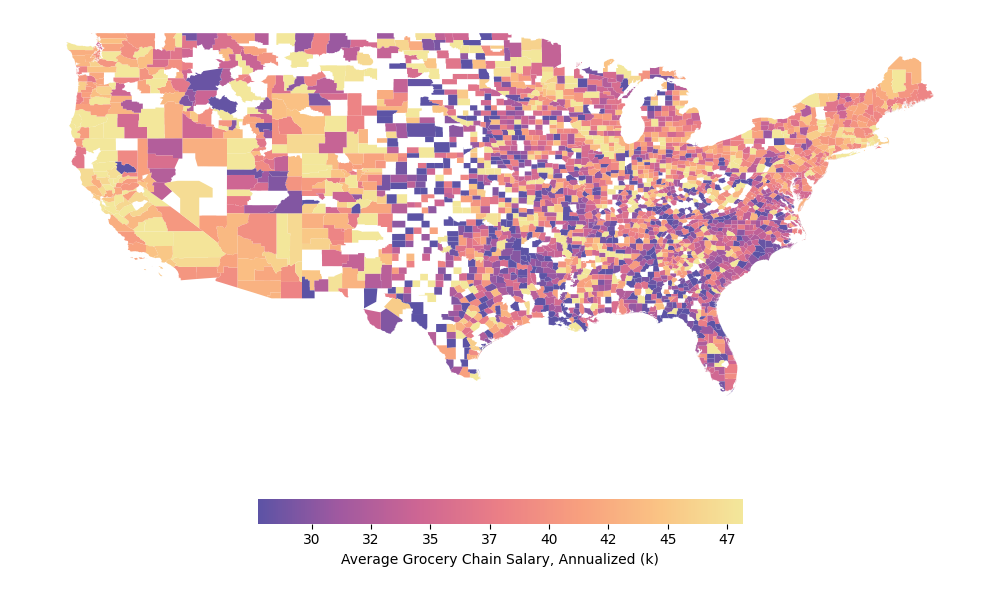

In [ ]:
%matplot plt 

In [ ]:
saveFigS3(figs_dir.replace("s3://ipsos-dvd/", "") + "wages_chloropleth.pdf", bucket = "ipsos-dvd")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Within vs. across county regression

In [ ]:

wages_chains = spark.read.parquet(data_dyn + "wagescape_chains_county")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wages_chains = wages_chains.withColumn("week", F.weekofyear(F.to_date("POST_DATE")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip = (wages_chains.groupBy("cz", "chain", "fips_county", "COUNTY", "STATE")
            .agg(F.percentile_approx("SALARY", 0.5).alias("SALARY_median"), 
                F.avg("SALARY").alias("SALARY"), 
                F.count("JOB_ID").alias("count")).fillna("NA")
           ).toPandas()
wage_zip[wage_zip == "NA"] = np.nan


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip = wage_zip[wage_zip['count'] > 5] # drop counties with few chain-county observations

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wage_zip['cz'] =  wage_zip['cz'].astype(str)
# wage_zip['fips_county'] =  wage_zip['fips_county'].astype(str)

wage_zip['chain_cz'] = wage_zip['chain'] + wage_zip['cz']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Step 4: Convert the results to a DataFrame for a nice table
results_df = getR2Df(pagg=wage_zip, fixed_effects=['cz', 'chain', 'chain_cz'], yvar="SALARY")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
results_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fixed Effect                 cz        chain     chain_cz
R-squared              0.159506     0.358587     0.770755
Adjusted R-squared     0.082791     0.351914     0.558928
No. Obs             7090.000000  7090.000000  7090.000000
No. FEs              593.000000    73.000000  3405.000000

In [ ]:
# Rename columns for LaTeX table
df_renamed = results_df.rename(columns={'cz' : 'Market',
                                'chain' : 'Chain',
                                'chain_cz' : 'Market x Chain'}
                       )

# Convert the first part of the DataFrame to LaTeX, excluding the last two rows
ltx = df_renamed.iloc[:-2].round(3).to_latex()

# Manually create LaTeX strings for the "No. Obs" and "No. FEs" rows
sum_row = df_renamed.iloc[-2:].astype(int).to_latex(header=False, index=True)

# Concatenate the strings, adding a \hline to separate the sections
final_ltx = ltx.split("\\bottomrule")[0]  + "\n\\hline\n" + "\n" + sum_row.split("\\toprule")[1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:

with open('temp.tex', 'w') as temp_file:
    temp_file.write(final_ltx)
s3_client = boto3.client('s3')
s3_client.upload_file('temp.tex', 'ipsos-dvd', 'dyn/results/tabs/wages_r2.tex')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Histogram

In [ ]:
test = wages_chains.toPandas()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
plt.style.use('ggplot')
plt.style.available

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(1,1)
wage_zip['SALARY'].hist(bins=100, ax=ax)
mdn = wage_zip['SALARY'].median()
plt.axvline(mdn, color="red")
plt.annotate(f'Median: {round(mdn)}', xy=(mdn+30000, 250), xytext=(5, -5), textcoords='offset points',
             horizontalalignment='right', verticalalignment='top', fontsize=14)
plt.grid(False)
plt.xlabel('Salary (Annualized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

# increase axis tick size
ax.tick_params(axis='x', labelsize='large') # For x-axis tick labels
ax.tick_params(axis='y', labelsize='large') # For y-axis tick labels

saveFigS3("dyn/results/figs/wages_hist.pdf", bucket = "ipsos-dvd")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

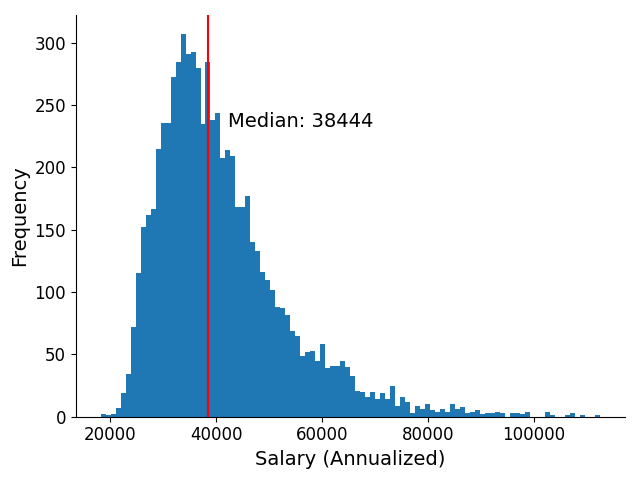

In [ ]:
%matplot plt

In [ ]:
wage_zip[wage_zip['SALARY'] > 100000]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       cz           chain  SALARY_median         SALARY           chain_cz
79    200         walmart       101000.0  101875.000000         walmart200
93    216         walmart       124507.0  124507.000000         walmart216
104   227          costco       101000.0  101000.000000          costco227
159    31      sam's club       101500.0  104250.000000       sam's club31
223    45          costco       112500.0  112500.000000           costco45
...   ...             ...            ...            ...                ...
5297  492         walmart       100500.0  101000.000000         walmart492
5345  540  dollar general       141280.0  141280.000000  dollar general540
5418  630          target       115000.0  106187.500000          target630
5447  695         safeway       114096.0  114096.000000         safeway695
5509   97      sam's club       109000.0  106333.333333       sam's club97

[88 rows x 5 columns]

### Aggregated at ZIP level

In [ ]:

wages_df_zip = wages_df.groupby(['chain', "ZIP", 'COUNTY', 'STATE', 'countystate', 'quarter']).agg({'SALARY' : 'mean'}).reset_index()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wages_df_zip['countychain'] = wages_df_zip['countystate'] + wages_df_zip['chain']
wages_df_zip['statechain'] = wages_df_zip['STATE'].astype(str) + wages_df_zip['chain']
wages_df_zip['STATE'] = wages_df_zip['STATE'].astype(str)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
wages_df_zip['countychain_q'] = wages_df_zip['countychain'] + wages_df_zip['quarter'].astype(str)
wages_df_zip['comp_q'] = wages_df_zip['chain'] + wages_df_zip['quarter'].astype(str)
wages_df_zip['county_q'] = wages_df_zip['countystate'] + wages_df_zip['quarter'].astype(str)
wages_df_zip['statechain_q'] = wages_df_zip['statechain'] + wages_df_zip['quarter'].astype(str)

wages_df_zip['zip_q'] = wages_df_zip['ZIP'] + wages_df_zip['quarter'].astype(str)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
formula = 'SALARY ~  0 | countychain_q  |0|0'

model_fe = fixedeffect(data_df = wages_df_zip,
                       formula = formula, noint=False,
                       no_print=True)
result = model_fe.fit()
result.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    High Dimensional Fixed Effect Regression Results                   
  Dep. Variable:          SALARY   R-squared(proj model):                    2.22e-16  
  No. Observations:       177693   Adj. R-squared(proj model):                -1.7616  
  DoF of residual:       64343.0   R-squared(full model):                      0.7818  
  Residual std err:    1.768e+04   Adj. R-squared(full model):                 0.3975  
  Covariance Type:     nonrobust   F-statistic(proj model):                         0  
  Cluster Method:     no_cluster   Prob (F-statistic (proj model)):               nan  
                                   DoF of F-test (proj model):         [0.0, 64343.0]  
                                   F-statistic(full model):                    2.0341  
                                   Prob (F-statistic (full model)):                 0  
                                   DoF of F-test (full model):        [113350, 64343]  
                    coef nonrobu

# Prices

### Match to store data

In [ ]:

places = spark.read.option("multiLine", "true") \
                .option("escape", "\"") \
                .option("quote", '"').csv(data_dir + "places/*.gz", header=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
brands = places.select("brands").distinct().toPandas()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
brands['brands'] = brands['brands'].str.lower()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
with fs.open("s3://ipsos-dvd/dyn/data/expanded_grocery_chains.json", 'rb') as f:
    s3_clientdata = json.load(f)
chains = s3_clientdata['expanded_grocery_chains']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
names = pd.DataFrame({'tech' : chains})


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
names['tech'] = names['tech'].str.lower()
names['tech_adj'] = names['tech']
names.loc[names['tech_adj'] == "hannaford"] = "hannaford supermarkets"
names.loc[names['tech_adj'] == "dillons"] = "dillons food stores"
names.loc[names['tech_adj'] == "harveys"] = "harveys supermarkets"
names.loc[names['tech_adj'] == "super 1 foods"] = "super one foods"
names.loc[names['tech_adj'] == "smith's"] = "smith's food and drug stores"
names.loc[names['tech_adj'] == "fry's"] = "fry's food & drug"
names.loc[names['tech_adj'] == "qfc"] = "quality food centers"
names = names[names['tech_adj'] != "save mart"]
names = names[names['tech_adj'] != "acme"]
names = names[names['tech_adj'] != "stater bros."]
names = names[names['tech_adj'] != "brookshire"]
names = names[names['tech_adj'] != "fresh by brookshire's"]
names = names[names['tech_adj'] != "wegmans"]
names = names[names['tech_adj'] != "roundy's"] # doesnt operate under this brand, need to redo the supermarket list




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:

names['matched'] = names.apply(lambda x: process.extractOne(x.tech_adj, list(brands['brands'])), axis=1)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
names['matched'] = names['matched'].apply(lambda x: x[0] if x != None else None)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# # inspect exhaustiveness (see paper text)
# print(places.filter((F.col("brands") == "Walmart") & (F.col("iso_country_code") == "US")).count())
# print(places.filter(F.col("brands") == "Kroger").count())
# print(places.filter(F.col("brands").contains("Wegmans Food Markets")).count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## filter places
temp = places.filter(F.lower(F.col("brands")).isin(list(names['matched'])))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# # this is fucking bullshit, just intersect with CBG shapefile
# redo_cbgs=False
# if redo_cbgs:
#     # add in cbg information from advan
#     fn_advan = "s3://external-advan/monthly_patterns/"
#     advan = spark.read.option("multiLine", "true") \
#                     .option("escape", "\"") \
#                    .option("quote", '"') \
#                     .option("recursiveFileLookup", "true") \
#                 .csv(fn_advan + "202{2,3}*", header=True)
#     advan = advan.repartition(1000, "DATE_RANGE_START")

#     cbgs = advan.select("PLACEKEY", "POI_CBG").dropDuplicates().toPandas()
#     cbgs.to_csv(data_dyn + "placekey_to_cbg.csv", index=False)
# cbgs = spark.read.csv(data_dyn + "placekey_to_cbg.csv", header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Intersect with CBGs

In [ ]:
# merge on CBG shapefiles
cbgs = ShapefileReader.readToGeometryRDD(sc, data_dyn + "census_bg_merged/")
cbgs = (Adapter.toDf(cbgs, cbgs.fieldNames, spark))

# gpd.read_file("s3://ipsos-dvd/ev/data/2020_cbgs/*")

cbgs = cbgs.repartition(1000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('3.0', '2.12', '1.4.0')]

In [ ]:
cbgs.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['geometry', 'statefp', 'countyfp', 'tractce', 'blkgrpce', 'geoid', 'namelsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat', 'intptlon']

In [ ]:
joined = spatialIntersection(temp, cbgs.select("geoid", "geometry").withColumnRenamed("geoid", "fips_cbg"), transform=False)
# I checked and all US locations are matched

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# merge in commuting zones 
cz = spark.read.csv(data_dyn + "geo/commuting_zones.csv", header=True)
cz = cz.withColumnRenamed("FIPS", "fips_county").withColumnRenamed("Commuting Zone ID, 2000", "cz").select("fips_county", "cz")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
joined = joined.withColumn("fips_county", F.substring("fips_cbg", 1,5)).join(cz, on = "fips_county", how = "left")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
joined.write.mode("overwrite").parquet(data_dyn + "places_chains_filtered_cbgs")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Filter Spend

In [ ]:
refilter_spend = False
if refilter_spend:
    spend = spark.read.parquet(os.path.join(data_dyn, "spend_places"))
    spend = spend.filter(F.lower(F.col("brands")).isin(list(names['matched'])))
    
    # add in chain names
    
    
    # merge in county and commuting zone
    places = spark.read.parquet(data_dyn + "places_chains_filtered_cbgs").select("placekey", "fips_cbg", "fips_county", "cz")
    spend = spend.join(places, on = "placekey", how = "left")

    spend.write.parquet(data_dyn + "spend_chains", mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spend = spark.read.parquet(os.path.join(data_dyn, "spend_places"))
spend = spend.filter(F.lower(F.col("brands")).isin(list(names['matched'])))

names_spark = names.rename(columns={'matched' : 'brands_lower', 'tech' : 'chain'})[['brands_lower', 'chain']]
names_spark = spark.createDataFrame(names_spark)
spend = spend.withColumn("brands_lower", F.lower(F.col("brands"))).join(names_spark, on = "brands_lower").drop("brands_lower")



# merge in county and commuting zone
places = spark.read.parquet(data_dyn + "places_chains_filtered_cbgs").select("placekey", "fips_cbg", "fips_county", "cz")
spend = spend.join(places, on = "placekey", how = "left")

spend.write.parquet(data_dyn + "spend_chains", mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Price analysis

In [ ]:
spend = spark.read.parquet(data_dyn + "spend_chains")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# # check what's not matched
# test = spend.select(F.lower("brands").alias("brands")).distinct().toPandas()
# [x for x in names['matched'] if x not in test['brands'].tolist()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# explode daily spend data
spend_by_day_schema = ArrayType(DoubleType())
spend_per_transaction_by_day_schema = ArrayType(DoubleType())

boom = spend\
    .withColumn("spend_by_day", F.from_json("spend_by_day", spend_by_day_schema))\
    .withColumn("spend_per_transaction_by_day", F.from_json("spend_per_transaction_by_day", spend_per_transaction_by_day_schema))\
    .withColumn("date_range", F.expr("sequence(spend_date_range_start, spend_date_range_end, interval 1 day)"))\
    .withColumn("zipped", F.arrays_zip("spend_by_day", "spend_per_transaction_by_day", "date_range"))\
    .withColumn("exploded", F.explode("zipped"))\
    .selectExpr("placekey", "brands", "chain", "spend_date_range_start", "spend_date_range_end", 
                "exploded.spend_by_day as spend", "fips_county", "cz", "fips_cbg",
                "exploded.spend_per_transaction_by_day as spend_per_transaction",
                "exploded.date_range as transaction_date")\
    .drop("zipped", "exploded", "date_range", "spend_by_day", "spend_per_transaction_by_day")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
quantiles = boom.agg(F.percentile_approx("spend_per_transaction", 0.005).alias("lower"), 
                     F.percentile_approx("spend_per_transaction", 0.995).alias("upper")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# winsorize
boom = boom.filter(F.col("spend_per_transaction").between(quantiles[0]['lower'], 
                                                          quantiles[0]['upper']))
boom.write.parquet(data_dyn + "prices_boom", mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# now aggregate to weekly
# Step 2: Calculate total spend per week for weighting
windowSpec = Window.partitionBy("brands", "placekey", "week")
boom = boom.withColumn("week", F.concat(F.weekofyear("transaction_date"), 
                                           F.year("transaction_date"))) \
    .withColumn("total_week_spend", F.sum("spend").over(windowSpec))

boomweek = boom \
    .groupBy("brands", "placekey", "spend_date_range_start", "spend_date_range_end", "week", 
             "cz", "fips_county", "fips_cbg",)\
    .agg(F.percentile_approx("spend_per_transaction", 0.5).alias("spend_per_transaction"))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
prices = boomweek.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# qtile = np.quantile(prices.loc[~prices['spend_per_transaction'].isna(), 'spend_per_transaction'], 0.99)
# prices = prices.loc[prices['spend_per_transaction'] < qtile]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
qtile = np.quantile(prices.loc[~prices['spend_per_transaction'].isna(), 'spend_per_transaction'], 0.999)
qtile

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

111.99249999999999

In [ ]:
prices['spend_per_transaction'].describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count    3.186751e+06
mean     2.343484e+01
std      1.516905e+01
min      2.000000e+00
25%      1.170000e+01
50%      2.025000e+01
75%      3.232000e+01
max      1.375000e+02
Name: spend_per_transaction, dtype: float64

In [ ]:
test = prices.copy()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
prices

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             brands             placekey  ...      fips_cbg spend_per_transaction
0              ALDI  222-222@5p7-2gj-zcq  ...  270414507012                 55.81
1              ALDI  222-222@5p7-2gj-zcq  ...  270414507012                 30.67
2              ALDI  222-222@5p7-2gj-zcq  ...  270414507012                 42.38
3              ALDI  222-222@5p7-2gj-zcq  ...  270414507012                 54.59
4              ALDI  222-222@5p7-2gj-zcq  ...  270414507012                 15.27
...             ...                  ...  ...           ...                   ...
3186746  Winn Dixie  zzy-22b@8dk-mwr-6rk  ...  120810020072                 26.29
3186747  Winn Dixie  zzy-22b@8dk-mwr-6rk  ...  120810020072                 49.20
3186748  Winn Dixie  zzy-22b@8dk-mwr-6rk  ...  120810020072                 17.10
3186749  Winn Dixie  zzy-22b@8dk-mwr-6rk  ...  120810020072                 21.28
3186750  Winn Dixie  zzy-22b@8dk-mwr-6rk  ...  120810020072                 29.95

[3186751 rows x

In [ ]:
# demean chain fixed effects
formula = 'spend_per_transaction ~  0 | brands  |0|0'

model_fe = fixedeffect(data_df = prices,
                       formula = formula, noint=False,
                       no_print=True)
result = model_fe.fit()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
prices['resid'] = result.resid

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Histogram

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

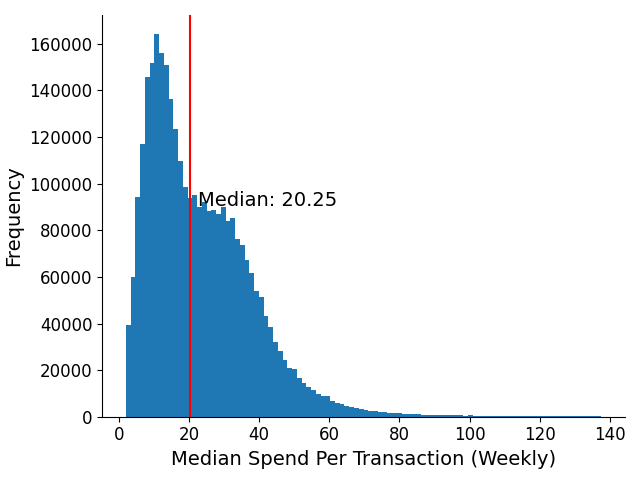

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(1,1)
prices['spend_per_transaction'].hist(bins=100)
mdn = prices['spend_per_transaction'].median()
plt.axvline(mdn, color="red")
plt.annotate(f'Median: {mdn}', xy=(mdn+40, 100000), xytext=(5, -5), textcoords='offset points',
             horizontalalignment='right', verticalalignment='top', fontsize=14)
plt.grid(False)
plt.xlabel('Median Spend Per Transaction (Weekly)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

# increase axis tick size
ax.tick_params(axis='x', labelsize='large') # For x-axis tick labels
ax.tick_params(axis='y', labelsize='large') # For y-axis tick labels

saveFigS3("dyn/results/figs/prices_hist.pdf", bucket = "ipsos-dvd")
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

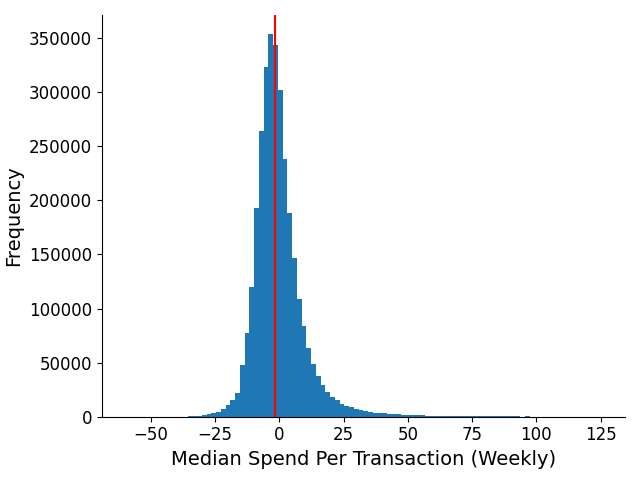

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(1,1)
prices['resid'].hist(bins=100)
mdn = prices['resid'].median()
plt.axvline(mdn, color="red")
# plt.annotate(f'Median: {mdn}', xy=(mdn+35000, 50000), xytext=(5, -5), textcoords='offset points',
#              horizontalalignment='right', verticalalignment='top', fontsize=14)
plt.grid(False)
plt.xlabel('Median Spend Per Transaction (Weekly)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

# increase axis tick size
ax.tick_params(axis='x', labelsize='large') # For x-axis tick labels
ax.tick_params(axis='y', labelsize='large') # For y-axis tick labels

saveFigS3("dyn/results/figs/prices_resid_hist.pdf", bucket = "ipsos-dvd")
#saveFigS3("dyn/results/figs/prices_hist.pdf", bucket = "ipsos-dvd")
%matplot plt

#### Regressions

In [ ]:
prices['cz_q'] = prices['cz'].astype(str) + prices['week'].astype(str)
prices['brand_q'] = prices['brands'] + prices['week'].astype(str)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
pagg = (prices.groupby(by=["placekey", "brands", "cz", "fips_county", "fips_cbg"])
            .agg({'spend_per_transaction' : 'median'})).reset_index()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
pagg.to_csv(data_dir, "prices_average.csv")

In [ ]:
pagg['cz'] = pagg['cz'].astype(str)
pagg['fips_county'] = pagg['fips_county'].astype(str)
pagg['fips_cbg'] = pagg['fips_cbg'].astype(str)
pagg['brands_cz'] = pagg['brands'] + pagg['fips_county']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
places = spark.read.parquet(data_dyn + "places_chains_filtered_cbgs").select('wkt_area_sq_meters', 'includes_parking_lot', 
                                                                            'placekey').toPandas()
pagg = pagg.merge(places, on = "placekey", how="left")
pagg['wkt_area_sq_meters'] = pagg['wkt_area_sq_meters'].astype(float)
pagg['area_2'] = pagg['wkt_area_sq_meters']**2


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Step 2: List of fixed effects to loop over
results_df = getR2Df(pagg=pagg)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Rename columns for LaTeX table
df_renamed = results_df.rename(columns={'cz' : 'Market', 'brands' : 'Chain', 'brands_cz' : 'Market x Chain'})

# Convert the first part of the DataFrame to LaTeX, excluding the last two rows
ltx = df_renamed.iloc[:-2].round(3).to_latex()

# Manually create LaTeX strings for the "No. Obs" and "No. FEs" rows
sum_row = df_renamed.iloc[-2:].astype(int).to_latex(header=False, index=True)

# Concatenate the strings, adding a \hline to separate the sections
final_ltx = ltx.split("\\bottomrule")[0]  + "\n\\hline\n" + "\n" + sum_row.split("\\toprule")[1]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
with open('temp.tex', 'w') as temp_file:
    temp_file.write(final_ltx)
s3_client = boto3.client('s3')
s3_client.upload_file('temp.tex', 'ipsos-dvd', 'dyn/results/tabs/prices_r2.tex')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Map

In [ ]:
boomweek = boom \
    .groupBy("cz", "fips_county")\
    .agg(F.percentile_approx("spend_per_transaction", 0.5).alias("spend_per_transaction"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
prices_map = boomweek.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:

s3.download_file('ipsos-dvd','dyn/data/geo/county_shapefile.zip','county_shapefile.zip')
county_shp = gpd.read_file('county_shapefile.zip')
county_shp = county_shp[['FIPS', 'geometry']].rename(columns={'FIPS' : 'fips_county'})


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# TODO: some missing, improve the match
prices_map = prices_map.merge(county_shp, on = "fips_county", how = "left")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
prices_map = gpd.GeoDataFrame(prices_map, geometry = prices_map.geometry)
prices_map.to_file(data_dyn + 'prices_map.geojson', driver="GeoJSON")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f"{int(x/1000)}"

# Define the custom color palette
colors = ['#f3e79b', '#fac484', '#f8a07e', '#eb7f86', '#ce6693', '#a059a0', '#5c53a5']

colors.reverse()
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))


vmin = np.quantile(prices_map['spend_per_transaction'], 0.1)
vmax = np.quantile(prices_map['spend_per_transaction'], 0.9)
# Plot the GeoDataFrame
prices_map.cx[-125:-66, 25:49].plot(column='spend_per_transaction',
                                      cmap=custom_cmap,
                                      ax=ax, vmin=vmin, vmax=vmax,
                                     rasterized=True)
# Manually add a colorbar with custom formatting
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Necessary for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5)
cbar.set_label("Median Spend Per Transaction, USD")
cbar.outline.set_visible(False)

ax.set_axis_off()

plt.tight_layout()
saveFigS3(figs_dir.replace("s3://ipsos-dvd/", "") + "prices_chloropleth.pdf", bucket = "ipsos-dvd")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

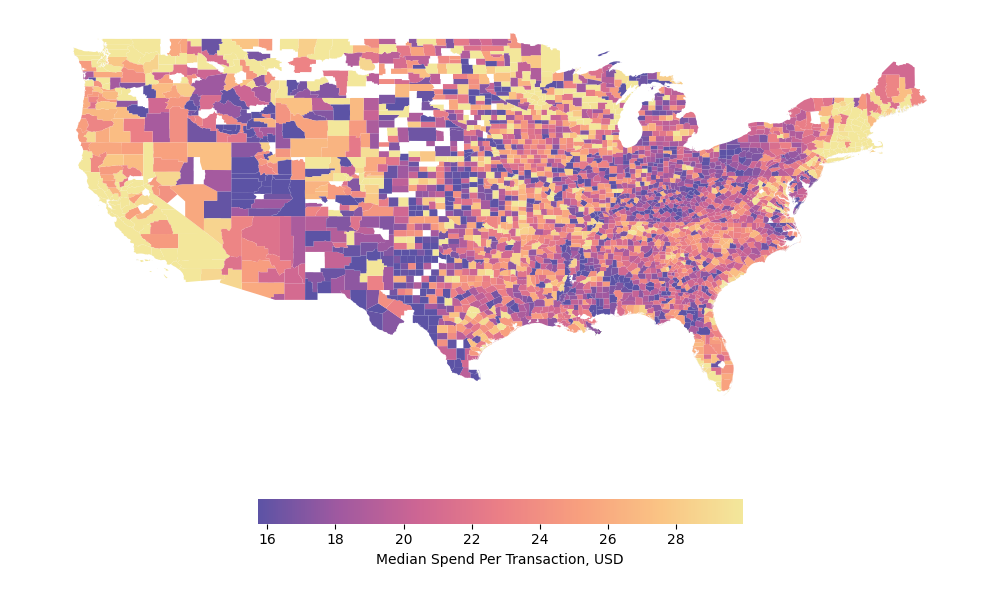

In [ ]:
%matplot plt

## Wages and prices combined

### County-chain-month level

In [3]:
boom = spark.read.parquet(data_dyn + "prices_boom")
price_panel = boom.withColumn("month", F.concat(F.month("transaction_date"), 
                                           F.year("transaction_date"))) \
    .groupBy("chain", "spend_date_range_start", "spend_date_range_end", "month", 
             "cz",) \
    .agg(F.percentile_approx("spend_per_transaction", 0.5).alias("spend_per_transaction")).toPandas()
price_panel['month'] = price_panel['month'].astype(str).str[:-4]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
wages_chains = spark.read.parquet(data_dyn + "wagescape_chains_county")
wage_zip = (wages_chains.withColumn("month", F.month(F.to_date("POST_DATE")))
            .groupBy("cz", "chain", "month")
            .agg(F.percentile_approx("SALARY", 0.5).alias("SALARY_median"), 
                F.avg("SALARY").alias("SALARY")).fillna("NA")
           ).toPandas()
wage_zip[wage_zip == "NA"] = np.nan

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
wage_zip['month'] = wage_zip['month'].astype(str)
combined = price_panel.merge(wage_zip, on = ['chain', 'cz', 'month'], how="inner")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
combined['wage_log'] = np.log(combined['SALARY'])
combined['price_log'] = np.log(combined['spend_per_transaction'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
combined.to_csv(data_dyn + "price_wage_panel_monthly.csv.gz")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Wages, Prices, and Location

In [12]:
# aggregate to chain level and merge in distances 
boom = spark.read.parquet(data_dyn + "prices_boom")
boom.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

16552006

In [13]:

distances = spark.read.csv(data_dyn + "distance_workers_shoppers.csv.gz", header=True)
boom = boom.join(distances.drop("cz"), on = "placekey", how = "left")
boom.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

16552006

In [14]:
price_panel = boom.groupBy("chain", "cz",) \
    .agg(F.percentile_approx("spend_per_transaction", 0.5).alias("spend_per_transaction"), 
        F.percentile_approx("distance_workers", 0.5).alias("distance_workers"),
        F.percentile_approx("distance_shoppers", 0.5).alias("distance_shoppers")).toPandas()

wages_chains = spark.read.parquet(data_dyn + "wagescape_chains_county")
wage_zip = (wages_chains.groupBy("cz", "chain")
            .agg(F.percentile_approx("SALARY", 0.5).alias("SALARY_median"), 
                F.avg("SALARY").alias("SALARY")).fillna("NA")
           ).toPandas()
wage_zip[wage_zip == "NA"] = np.nan
combined = price_panel.merge(wage_zip, on = ['chain', 'cz'], how="inner")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
combined[['wage_log', 'price_log', 'distance_workers_log', 'distance_shoppers_log']] = \
    combined[['SALARY', 'spend_per_transaction', 'distance_workers', 'distance_shoppers']].apply(np.log, axis=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
combined[['distance_workers_sq', 'distance_shoppers_sq']] = combined[['distance_workers', 'distance_shoppers']].apply(lambda x: x**2, axis=1)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
combined.to_csv(data_dyn + "price_wage_panel_distances.csv.gz", index=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
combined.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              chain   cz  ...  distance_workers_sq  distance_shoppers_sq
0        albertsons  447  ...             0.146586             11.607649
1        albertsons  581  ...            19.691098             14.915044
2        albertsons  647  ...             1.790801             43.151761
3              aldi  196  ...             0.178073            120.450625
4              aldi  231  ...            33.073326             84.419344
...             ...  ...  ...                  ...                   ...
4737   trader joe's   80  ...             3.243416             84.474481
4738   weis markets  113  ...             2.205566             51.394561
4739       foodtown  250  ...             5.568561              2.039184
4740  piggly wiggly  442  ...             0.699623             72.046144
4741  piggly wiggly  416  ...             1.934463            183.412849

[4742 rows x 13 columns]